In [ ]:
#Environment: env:Quiskit

#https://www.analyticsvidhya.com/blog/2021/06/natural-language-processing-sentiment-analysis-using-lstm/
#https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [9]:
!pip install nltk

In [46]:
!pip install wordcloud

In [7]:
!pip install keras

In [10]:
!pip install tensorflow

  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Using cached tensorboard_plugin_wit-1.8.0-py3-none-any.whl (781 kB)
  Using cached cachetools-4.2.4-py3-none-any.whl (10 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached requests_oauthlib-1.3.0-py2.py3-none-any.whl (23 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
  Using cached oauthlib-3.1.1-py2.py3-none-any.whl (146 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlflow 1.20.2 requires cloudpickle, which is not installed.
mlflow 1.20.2 requires Flask, which is not installed.
mlflow 1.20.2 requires gitpython>=2.1.0, which is not installed.
mlflow 1.20.2 requires pyyaml>=5.1, which is not installed.
mlflow 1.20.2 requires sqlalchemy, which is not installed.


In [1]:
# Importing required libraries
import nltk
import pandas as pd
from nltk.corpus import stopwords
from textblob import Word #Lammetization
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, recall_score, precision_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

In [6]:
#Loading the dataset
data = pd.read_csv('amazon_alexa.tsv')
# Creating a new column sentiment based on overall ratings
def sentiments(df):
  if df['rating'] > 3.0:
    return 'Positive'
  elif df['rating'] <= 3.0:
    return 'Negative'
data['sentiment'] = data.apply(sentiments, axis=1)

In [7]:
data.sentiment.value_counts()

Positive    2741
Negative     409
Name: sentiment, dtype: int64

In [ ]:
#Imbalance Dataset

In [8]:
data

,rating,date,variation,verified_reviews,feedback,sentiment
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,Positive
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,Positive
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,Positive
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,Positive
4,5,31-Jul-18,Charcoal Fabric,Music,1,Positive
...,...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1,Positive
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1,Positive
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1,Positive
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1,Positive


In [9]:
#Check if there are any null values
data_v1 = data[['verified_reviews','sentiment']]
data_v1.isnull().sum()

verified_reviews    0
sentiment           0
dtype: int64

In [10]:
data_v1

,verified_reviews,sentiment
0,Love my Echo!,Positive
1,Loved it!,Positive
2,"Sometimes while playing a game, you can answer...",Positive
3,I have had a lot of fun with this thing. My 4 ...,Positive
4,Music,Positive
...,...,...
3145,"Perfect for kids, adults and everyone in betwe...",Positive
3146,"Listening to music, searching locations, check...",Positive
3147,"I do love these things, i have them running my...",Positive
3148,Only complaint I have is that the sound qualit...,Positive


In [11]:
def cleaning(df, stop_words):

    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: 
            ' '.join(x.lower() for x in x.split()))

#     # Replacing the special characters
    df['verified_reviews'] = df['verified_reviews'].str.replace('[^A-Za-z\s]+', '')
    
    # Replacing the digits/numbers

    df['verified_reviews'] = df['verified_reviews'].replace(to_replace=r'\d', value='', regex=True)
#     df['P'].str.replace(r'\D+', '').astype('int')

    # Removing stop words
    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: 
            ' '.join(x for x in x.split() if x not in stop_words))

    # Lemmatization
    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: 
            ' '.join([Word(x).lemmatize() for x in x.split()]))

    return df

stop_words = stopwords.words('english')

data_v1 = cleaning(data_v1, stop_words)
data_v1


C:\Users\admin\AppData\Local\Temp/ipykernel_18616/808047554.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['verified_reviews'] = df['verified_reviews'].apply(lambda x:
C:\Users\admin\AppData\Local\Temp/ipykernel_18616/808047554.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['verified_reviews'] = df['verified_reviews'].str.replace('[^A-Za-z\s]+', '')
C:\Users\admin\AppData\Local\Temp/ipykernel_18616/808047554.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

,verified_reviews,sentiment
0,love echo,Positive
1,loved,Positive
2,sometimes playing game answer question correct...,Positive
3,lot fun thing yr old learns dinosaur control l...,Positive
4,music,Positive
...,...,...
3145,perfect kid adult everyone,Positive
3146,listening music searching location checking ti...,Positive
3147,love thing running entire home tv light thermo...,Positive
3148,complaint sound quality isnt great mostly use ...,Positive


In [12]:
data_v1

,verified_reviews,sentiment
0,love echo,Positive
1,loved,Positive
2,sometimes playing game answer question correct...,Positive
3,lot fun thing yr old learns dinosaur control l...,Positive
4,music,Positive
...,...,...
3145,perfect kid adult everyone,Positive
3146,listening music searching location checking ti...,Positive
3147,love thing running entire home tv light thermo...,Positive
3148,complaint sound quality isnt great mostly use ...,Positive


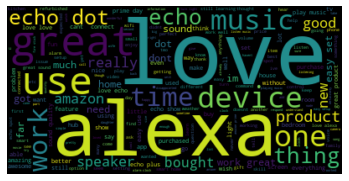

In [13]:
import wordcloud 
common_words=''
for i in data_v1.verified_reviews:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [14]:
# Encoded the target column
lb=LabelEncoder()
data_v1['sentiment'] = lb.fit_transform(data_v1['sentiment'])

C:\Users\admin\AppData\Local\Temp/ipykernel_18616/3474884211.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_v1['sentiment'] = lb.fit_transform(data_v1['sentiment'])


In [10]:
data_v1

,verified_reviews,sentiment
0,love echo,1
1,loved,1
2,sometimes playing game answer question correct...,1
3,lot fun thing yr old learns dinosaur control l...,1
4,music,1
...,...,...
3145,perfect kid adult everyone,1
3146,listening music searching location checking ti...,1
3147,love thing running entire home tv light thermo...,1
3148,complaint sound quality isnt great mostly use ...,1


In [41]:
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(data_v1['verified_reviews'].values)
X = tokenizer.texts_to_sequences(data['verified_reviews'].values)
X = pad_sequences(X)

In [50]:
X[2]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
       208, 110, 241, 148,  93,   4,  47, 460,   7,  61,  54, 252,  24])

In [12]:
model = Sequential()
model.add(Embedding(500, 120, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['Recall','Precision'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 156, 120)          60000     
                                                                 
 spatial_dropout1d (SpatialD  (None, 156, 120)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 176)               209088    
                                                                 
 dense (Dense)               (None, 2)                 354       
                                                                 
Total params: 269,442
Trainable params: 269,442
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
#Splitting the data into training and testing
y=pd.get_dummies(data_v1['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [14]:
batch_size=32
model.fit(X_train, y_train, epochs = 5, batch_size=batch_size, verbose = 'auto')

Epoch 1/5
69/69 [==============================] - 67s 885ms/step - loss: 0.3865 - recall: 0.8703 - precision: 0.8703
Epoch 2/5
69/69 [==============================] - 61s 881ms/step - loss: 0.2824 - recall: 0.8862 - precision: 0.8862
Epoch 3/5
69/69 [==============================] - 60s 869ms/step - loss: 0.2063 - recall: 0.9197 - precision: 0.9197
Epoch 4/5
69/69 [==============================] - 61s 878ms/step - loss: 0.1716 - recall: 0.9297 - precision: 0.9297
Epoch 5/5
69/69 [==============================] - 61s 879ms/step - loss: 0.1509 - recall: 0.9383 - precision: 0.9383


In [15]:
model.evaluate(X_test,y_test)

30/30 [==============================] - 4s 102ms/step - loss: 0.2888 - recall: 0.8878 - precision: 0.8878


[0.28884297609329224, 0.8878306746482849, 0.8878306746482849]

We have completed building our LSTM model for classifying the sentiments for amazon Alexa product reviews into ‘positive’ and ‘negative’ categories. The accuracy of the model is 90.9%. We can further tune the hyperparameters to improve the performance of the model.